In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, learning_curve, validation_curve
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from MajorityVoteClassifier import MajorityVoteClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
%matplotlib inline

In [2]:
path = "https://raw.githubusercontent.com/DSEI21000-S21/project-tennis-ml/main/wta_matches/wta_matches-2000-2021_expanded.csv"

def readData(path):
    df = pd.read_csv(path)
    return df

def dropGibberishRows(dataframe, column_name, filter_variable):
    index_list = list(dataframe[dataframe[column_name] == filter_variable].index)
    dataframe = dataframe.drop(index_list)
    return dataframe

#def encodeColumn(dataframe, column_list = []):
    #df = pd.get_dummies(dataframe, columns= column_list)
    #return df

def convertDate(dataframe, date):
    dataframe[date] = pd.to_datetime(dataframe[date], format = '%Y%m%d', errors='coerce')
    return dataframe

def addDateFeatures(dataframe, date):
    dataframe['year'] = dataframe[date].dt.year
    dataframe['month'] = dataframe[date].dt.month
    dataframe['day'] = dataframe[date].dt.day
    return dataframe

def appendTarget(dataframe, winner, loser):
    dataframe[winner] = 1
    dataframe[loser] = 0
    return dataframe

def getMissingDataPercentage(dataframe):
    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame({'column_name': dataframe.columns,
                                 'percent_missing': percent_missing})
    pd.set_option("max_rows", None)
    return missing_value_df

def formatColumns(dataframe):
    columns = list(dataframe.columns)
    renamed_columns = [i.lower().strip().replace(' ', "_").replace(':','') for i in columns]
    renamed_columns_dict = {columns[i]: renamed_columns[i] for i in range(len(columns))}
    dataframe = dataframe.rename(columns = renamed_columns_dict)
    return dataframe

def convertColumnsToNumeric(dataframe, columns = []):
    dataframe[columns] = dataframe[columns].apply(pd.to_numeric, errors ='coerce')
    return dataframe 

def fillMissingDataMode(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(dataframe[cols].mode().iloc[0])
    return dataframe

def dropColumn(dataframe, column_list = []):
    return dataframe.drop(column_list, axis =1)

def fillMissingDataMean(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(dataframe[cols].mean().iloc[0])
    return dataframe

def fillMissingData999(dataframe, cols):
    dataframe[cols]= dataframe[cols].fillna(999)
    return dataframe

In [3]:
wta_data = readData(path)
wta_data = dropColumn(wta_data, ['player_entry'])
wta_data = fillMissingDataMode(wta_data, ['surface', 'player_hand'])
wta_data = fillMissingDataMean(wta_data, ['player_height', 'player_age', 'minutes', 'ace', 'double_fault', 'service_points_won', 'first_serve_made', 'first_serve_won', 
'second_serve_won', 'serve_game', 'break_point_saved', 'break_point_faced', 'player_rank','player_rank_points'])
wta_data = fillMissingData999(wta_data, ['player_seed'])
wta_data = convertDate(wta_data, 'tourney_date')
wta_data = addDateFeatures(wta_data, 'tourney_date')
wta_data = dropColumn(wta_data, ['player_ioc', 'score', 'tourney_id', 'tourney_date', 'player_name'])
#wta_data = encodeColumn(wta_data, ['tourney_name','surface', 'tourney_level', 'player_hand','round'])
wta_data = formatColumns(wta_data)

In [4]:
getMissingDataPercentage(wta_data)

,column_name,percent_missing
tourney_name,tourney_name,0.0
surface,surface,0.0
draw_size,draw_size,0.0
tourney_level,tourney_level,0.0
match_num,match_num,0.0
player_id,player_id,0.0
player_seed,player_seed,0.0
player_hand,player_hand,0.0
player_height,player_height,0.0
player_age,player_age,0.0


In [5]:
wta_data.info(verbose =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119438 entries, 0 to 119437
Data columns (total 28 columns):
tourney_name          119438 non-null object
surface               119438 non-null object
draw_size             119438 non-null int64
tourney_level         119438 non-null object
match_num             119438 non-null int64
player_id             119438 non-null int64
player_seed           119438 non-null float64
player_hand           119438 non-null object
player_height         119438 non-null float64
player_age            119438 non-null float64
best_of               119438 non-null int64
round                 119438 non-null object
minutes               119438 non-null float64
ace                   119438 non-null float64
double_fault          119438 non-null float64
service_points_won    119438 non-null float64
first_serve_made      119438 non-null float64
first_serve_won       119438 non-null float64
second_serve_won      119438 non-null float64
serve_game            119438

In [6]:
wta_data.describe()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,second_serve_won,serve_game,break_point_saved,break_point_faced,player_rank,player_rank_points,target,year,month,day
count,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,...,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000,119438.000000
mean,54.576600,82.883705,202298.029580,678.641488,173.385424,24.219136,3.002579,155.925050,72.479200,73.225291,...,78.019033,131.635498,73.627145,75.859651,95.349947,1242.600897,0.500000,2009.847620,5.331821,16.041829
std,41.109025,171.380133,3351.576382,463.529275,5.000963,4.647098,0.071770,37.753336,84.053933,83.532933,...,79.508748,71.195287,83.105517,81.282219,127.100176,1439.037247,0.500002,6.066933,2.911543,8.638772
min,2.000000,1.000000,200001.000000,1.000000,153.000000,14.039699,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000
25%,30.000000,9.000000,201212.000000,11.000000,173.000000,21.122519,3.000000,173.385424,1.000000,3.000000,...,10.000000,17.000000,3.000000,7.000000,26.000000,391.000000,0.000000,2005.000000,3.000000,8.000000
50%,32.000000,25.000000,201450.000000,999.000000,173.385424,23.956194,3.000000,173.385424,5.000000,6.000000,...,17.000000,173.385424,8.000000,13.000000,60.000000,777.000000,0.500000,2010.000000,5.000000,16.000000
75%,64.000000,92.000000,201619.000000,999.000000,174.000000,26.964408,3.000000,173.385424,173.385424,173.385424,...,173.385424,173.385424,173.385424,173.385424,113.000000,1470.000000,1.000000,2015.000000,8.000000,23.000000
max,128.000000,2701.000000,223140.000000,999.000000,189.000000,173.385424,5.000000,2475.000000,173.385424,173.385424,...,173.385424,173.385424,173.385424,173.385424,1482.000000,13615.000000,1.000000,2021.000000,12.000000,31.000000


In [7]:
wta_data.head()

,tourney_name,surface,draw_size,tourney_level,match_num,player_id,player_seed,player_hand,player_height,player_age,...,second_serve_won,serve_game,break_point_saved,break_point_faced,player_rank,player_rank_points,target,year,month,day
0,Fed Cup G1 PO: JPN vs CHN,Hard,4,D,1,201419,999.0,R,172.000000,18.173854,...,173.385424,173.385424,173.385424,173.385424,190.0,121.0,1,2000,4,30
1,Fed Cup G1 PO: JPN vs CHN,Hard,4,D,2,200085,999.0,R,163.000000,24.821355,...,173.385424,173.385424,173.385424,173.385424,22.0,1230.0,1,2000,4,30
2,Fed Cup WG SF: USA vs BEL,Carpet,4,D,1,200652,999.0,L,173.385424,26.973306,...,173.385424,173.385424,173.385424,173.385424,4.0,3255.0,1,2000,11,22
3,Fed Cup WG SF: USA vs BEL,Carpet,4,D,2,200128,999.0,R,189.000000,24.457221,...,173.385424,173.385424,173.385424,173.385424,2.0,5022.0,1,2000,11,22
4,Fed Cup WG SF: CZE vs ESP,Carpet,4,D,1,200017,999.0,R,173.385424,28.928131,...,173.385424,173.385424,173.385424,173.385424,9.0,2132.0,1,2000,11,21


**check for missing values**

In [8]:
#Total missing values
wta_data.isnull().sum().sum()

0

In [9]:
# Random Seed
SEED = 42
np.random.seed = SEED

**check if the data is balance**     
target is our target variable, we want to make sure the data is balanced

In [10]:
#check if the data is balance
wta_data['target'].value_counts()

1    59719
0    59719
Name: target, dtype: int64

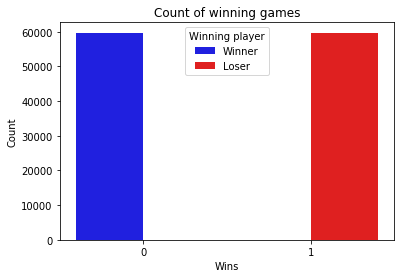

In [11]:
ax = sns.countplot(wta_data['target'], hue=wta_data['target'], palette=['blue', 'red'])
ax.set(xlabel='Wins', ylabel='Count')
ax.legend(title='Winning player', loc='upper center', labels=['Winner', 'Loser'])
ax.set_title('Count of winning games')
plt.show()

**Checking correlation between features**

In [12]:
wta_data_corr = wta_data.corr()
wta_data_corr['target'].sort_values(ascending=False)

target                1.000000e+00
player_rank_points    1.841243e-01
player_height         3.715075e-02
first_serve_won       1.893883e-02
player_age            1.001561e-02
second_serve_won      7.220266e-03
ace                   3.701899e-03
first_serve_made      3.578390e-04
serve_game            2.823581e-04
month                 1.006312e-18
best_of              -1.036141e-19
draw_size            -2.575920e-19
day                  -8.126050e-19
match_num            -4.078054e-18
minutes              -7.204443e-18
year                 -1.129621e-17
double_fault         -2.578640e-03
break_point_saved    -3.247645e-03
service_points_won   -7.119074e-03
break_point_faced    -1.264895e-02
player_id            -4.991135e-02
player_rank          -1.104391e-01
player_seed          -2.060586e-01
Name: target, dtype: float64

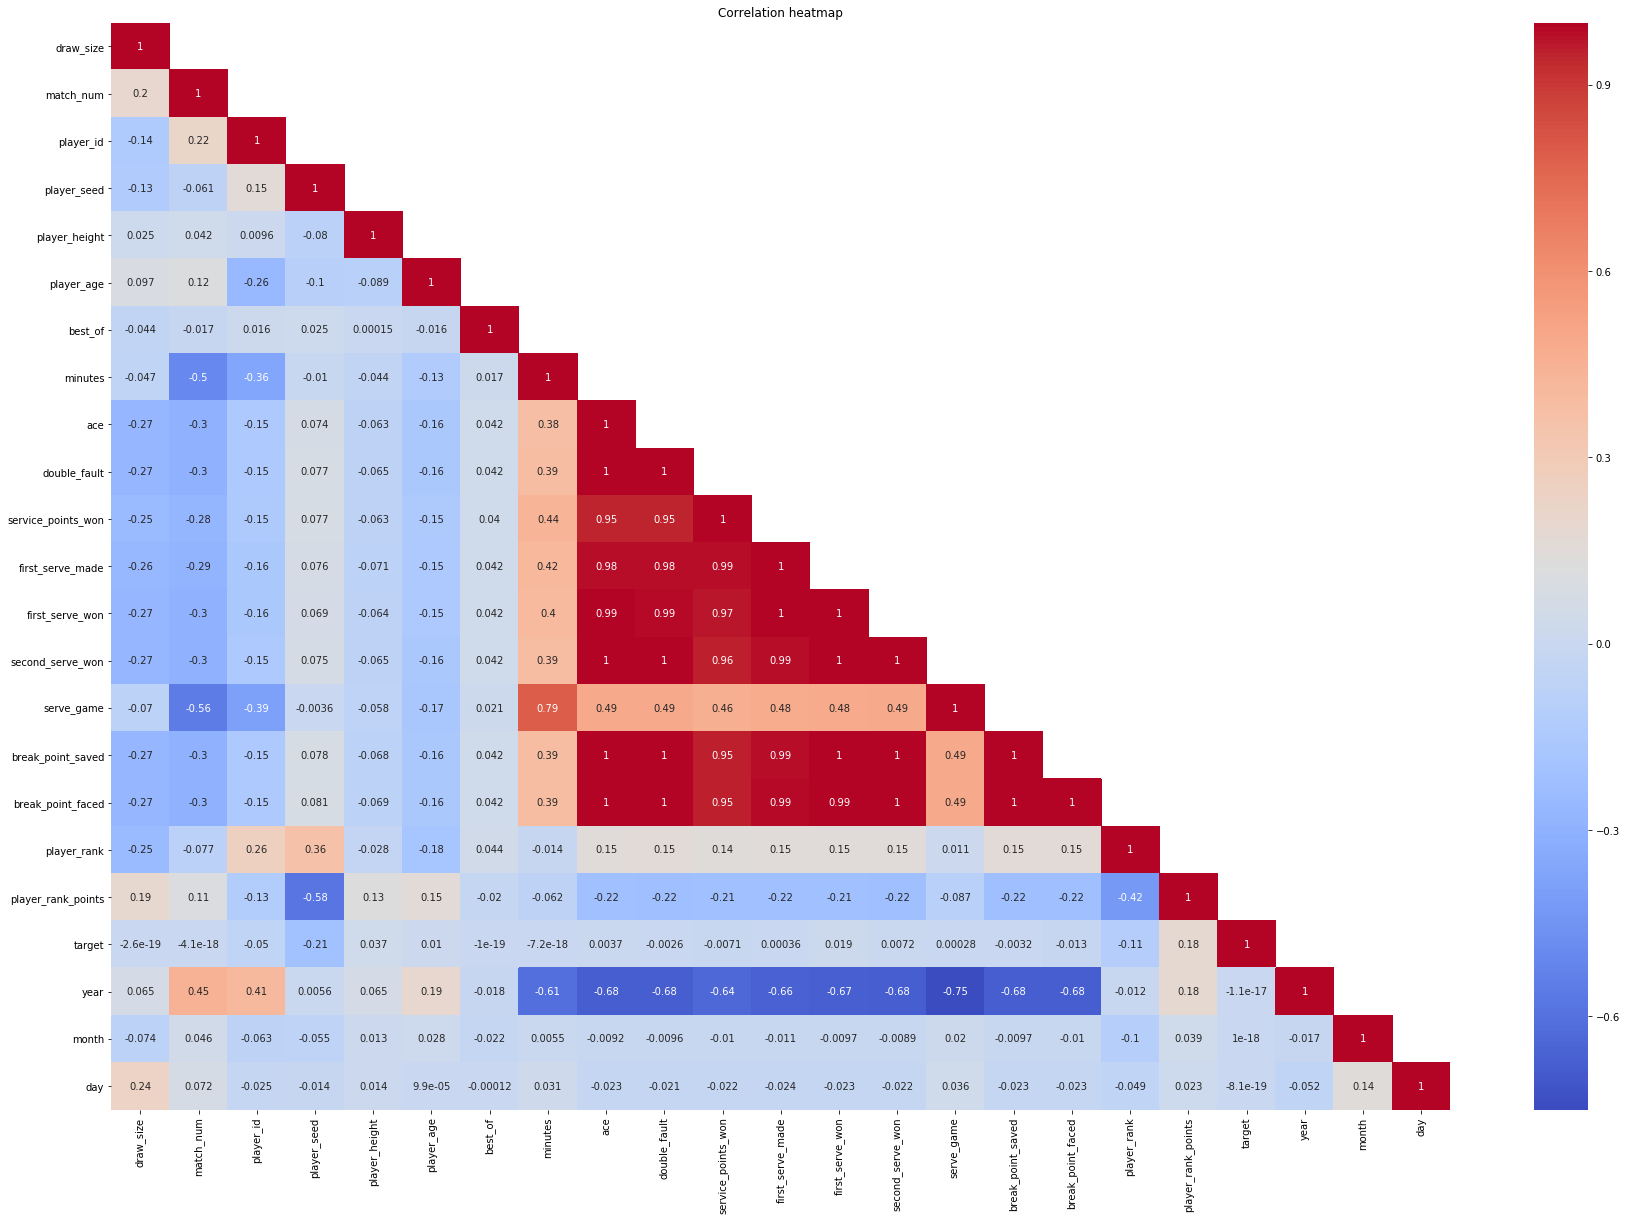

In [13]:
f, ax = plt.subplots(figsize= (30, 20))
lower = wta_data_corr.where(np.tril(np.ones(wta_data_corr.shape)).astype(np.bool))
hmap=sns.heatmap(lower,cmap="coolwarm", annot=True)
ax.set_title('Correlation heatmap')
plt.savefig('clean-corr-half.png')

**player_rank_points** is the highest positively correlated variable to the target variabl whereas **player_seed** is the negatively correlated to the target variable. 

**Convert the categorical columns to numeric**

In [14]:
def encodeColumn(dataframe, column_list = []):
    df = pd.get_dummies(dataframe, columns= column_list)
    return df

In [15]:
wta_data_numerical = encodeColumn(wta_data, ['tourney_name','surface', 'tourney_level', 'player_hand','round'])
wta_data_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119438 entries, 0 to 119437
Columns: 2782 entries, draw_size to round_SF
dtypes: float64(15), int64(8), uint8(2759)
memory usage: 335.2 MB


In [16]:
reduced_df = wta_data_numerical[(wta_data_numerical['year']== 2018 & 2019)]
reduced_df.head()

,draw_size,match_num,player_id,player_seed,player_height,player_age,best_of,minutes,ace,double_fault,...,player_hand_U,round_BR,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
51963,32,270,202469,2.0,182.000000,25.018480,3,72.0,7.0,0.0,...,0,0,0,0,0,0,1,0,0,0
51964,32,271,215035,999.0,173.385424,18.417522,3,182.0,3.0,9.0,...,0,0,0,0,0,0,1,0,0,0
51965,32,272,203435,999.0,173.385424,27.561944,3,151.0,4.0,6.0,...,0,0,0,0,0,0,1,0,0,0
51966,32,273,202506,999.0,173.385424,24.120465,3,98.0,1.0,3.0,...,0,0,0,0,0,0,1,0,0,0
51967,32,274,201465,9.0,165.000000,32.761123,3,71.0,6.0,2.0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5694 entries, 51963 to 116869
Columns: 2782 entries, draw_size to round_SF
dtypes: float64(15), int64(8), uint8(2759)
memory usage: 16.0 MB


**Split data into training and testing sets**

In [18]:
X = reduced_df.loc[:, reduced_df.columns != 'target']
y = reduced_df['target']



**Methodology**

We will be doing feature scaling using standardization. We will then compare the models with and without features scaled. Except for decision trees and random forests.

**Split the data and Standardization**

In [21]:

#standardize both training and testing data
sc = StandardScaler()
X_std = sc.fit_transform(X)
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=SEED)

**Apply the models on the Standardized Data**

**KNN**

In [22]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

knn_ubal = KNeighborsClassifier(n_neighbors=28, metric='minkowski', p=2, weights='uniform')
knn_pipe = make_pipeline(knn_ubal)
knn_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = knn_pipe.predict(X_std_train)
y_std_ts_pred = knn_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

Accuracy score on train: 0.5851944792973651
Accuracy score on test: 0.47805734347571677

f1 score on train: 0.5342349957734573
f1 score on test: 0.42077922077922075

Precision score on train: 0.609254498714653
Precision score on test: 0.47230320699708456

Recall score on train: 0.4756648268941295
Recall score on test: 0.3793911007025761



**Logistic Regression**

In [23]:
lr = LogisticRegression()
lr_pipe = make_pipeline(lr)
lr_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = lr_pipe.predict(X_std_train)
y_std_ts_pred = lr_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score on train: 0.8316185696361356
Accuracy score on test: 0.8080748976009362

f1 score on train: 0.8319559228650139
f1 score on test: 0.8114942528735631

Precision score on train: 0.8305
Precision score on test: 0.7968397291196389

Recall score on train: 0.8334169593577522
Recall score on test: 0.8266978922716628



**DecisionTree**

In [24]:
dt = DecisionTreeClassifier()
dt_pipe = make_pipeline(dt)
dt_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = dt_pipe.predict(X_std_train)
y_std_ts_pred = dt_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

Accuracy score on train: 1.0
Accuracy score on test: 0.7267407840842598

f1 score on train: 1.0
f1 score on test: 0.7264206209724662

Precision score on train: 1.0
Precision score on test: 0.7268464243845252

Recall score on train: 1.0
Recall score on test: 0.7259953161592506



**Random Forest**

In [25]:
rf = RandomForestClassifier()
rf_pipe = make_pipeline(rf)
rf_pipe.fit(X_std_train, y_std_train)

y_std_tr_pred = rf_pipe.predict(X_std_train)
y_std_ts_pred = rf_pipe.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy score on train: 0.986198243412798
Accuracy score on test: 0.657694558221182

f1 score on train: 0.9860724233983287
f1 score on test: 0.628099173553719

Precision score on train: 0.995398773006135
Precision score on test: 0.6870653685674548

Recall score on train: 0.9769192172604114
Recall score on test: 0.5784543325526932



**SVC**

In [26]:
svc = SVC()
svc.fit(X_std_train, y_std_train)

y_std_tr_pred = svc.predict(X_std_train)
y_std_ts_pred = svc.predict(X_std_test)

print("Accuracy score on train: {}\nAccuracy score on test: {}\n".format(accuracy_score(y_std_train, y_std_tr_pred), 
                                                                         accuracy_score(y_std_test, y_std_ts_pred)))

print("f1 score on train: {}\nf1 score on test: {}\n".format(f1_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                             f1_score(y_std_test, y_std_ts_pred, average='binary')))

print("Precision score on train: {}\nPrecision score on test: {}\n".format(precision_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                           precision_score(y_std_test, y_std_ts_pred, average='binary')))

print("Recall score on train: {}\nRecall score on test: {}\n".format(recall_score(y_std_train, y_std_tr_pred, average='binary'), 
                                                                     recall_score(y_std_test, y_std_ts_pred, average='binary')))

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score on train: 0.6373902132998746
Accuracy score on test: 0.593329432416618

f1 score on train: 0.5800639349026446
f1 score on test: 0.533869885982562

Precision score on train: 0.6892265193370166
Precision score on test: 0.6248037676609105

Recall score on train: 0.5007526342197692
Recall score on test: 0.46604215456674475



# GridSearchCV

**Logistic Regression**

In [27]:
lr = LogisticRegression(random_state= 42, C = 1)

param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr_cv = GridSearchCV(lr, param_grid, cv=10)
lr_cv.fit(X_std_train, y_std_train)

y_std_tr_pred = lr_cv.predict(X_std_train)
y_std_ts_pred = lr_cv.predict(X_std_test)

print(lr_cv.best_params_) 
print(lr_cv.best_score_)

C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JAH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

{'C': 1.0}
0.7894604767879548


In [28]:
#accuracy score on the training set
accuracy_score(y_std_train, y_std_tr_pred) 

0.8316185696361356

In [29]:
#accuracy score on the testing set
accuracy_score(y_std_train, y_std_ts_pred) 

ValueError: Found input variables with inconsistent numbers of samples: [3985, 1709]

**KNN**

In [30]:
param_grid = {'n_neighbors': np.arange(1,10)} 

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=10) 
knn_cv.fit(X_std_train, y_std_train)

y_std_tr_pred = knn_cv.predict(X_std_train)
y_std_ts_pred = knn_cv.predict(X_std_test)

print(knn_cv.best_params_) 
print(knn_cv.best_score_)

{'n_neighbors': 5}
0.5141781681304893


In [31]:
#accuracy score on the training set
accuracy_score(y_std_train, y_std_tr_pred) 

0.6936010037641155

In [ ]:
#accuracy score on the testing set
accuracy_score(y_std_train, y_std_ts_pred) 

**SVM**

In [ ]:
svc = SVC(kernel="linear", random_state=SEED)


param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

svc_gs = GridSearchCV(svc, param_grid, cv=10)
svc_gs.fit(X_std_train, y_std_train)
y_std_tr_pred = svc_gs.predict(X_std_train)
y_std_ts_pred = svc_gs.predict(X_std_test)

print(svc_gs.best_score_)
print(svc_gs.best_params_)

In [ ]:
#accuracy score on the training set
accuracy_score(y_std_train, y_std_tr_pred) 

In [ ]:
#accuracy score on the testing set
accuracy_score(y_std_train, y_std_ts_pred) 

In [ ]:
reduced_df_french = wta_data_numerical[(wta_data_numerical['year']== 2020) & (wta_data_numerical[(wta_data_numerical['tourney_name_roland_garros']==1)])
reduced_df_french.head()

In [ ]:
X_20 = reduced_df_french.loc[:, reduced_df_french.columns != 'target']
y_20 = reduced_df_french['target']


In [ ]:
X_20_pred = lr_cv.predict(X_20 )

accuracy_score(y_20, X_20_pred)

In [ ]:
X_20_pred

In [ ]:
#add a column to X_20_pred
reduced_df_french['predicted_values']=reduced_df_french[]